In [1]:
# Imports 
import torch
from PIL import Image 
from torchvision import transforms
import torchvision
from sklearn.metrics import jaccard_score
from sklearn.metrics import accuracy_score as sk_accuracy
from torch.utils.data import Dataset
from torchvision import transforms
import glob 
import os 
from torch.utils.data import DataLoader 
from torch import nn
from torch.nn import functional as F
from torchvision.models.segmentation import deeplabv3_resnet50 


In [2]:
# TODO: Save in drive? 
!wget http://tdd.ece.tufts.edu/Tufts_Dental_Database/Expert.zip
!unzip Expert.zip
!wget http://tdd.ece.tufts.edu/Tufts_Dental_Database/Radiographs.zip
!unzip Radiographs.zip
!wget http://tdd.ece.tufts.edu/Tufts_Dental_Database/Student.zip
!unzip Student.zip
!wget http://tdd.ece.tufts.edu/Tufts_Dental_Database/Segmentation.zip
!unzip Segmentation.zip

Streaming output truncated to the last 5000 lines.
  inflating: Student/gaze_map/gray/1021.JPG  
  inflating: Student/gaze_map/gray/1024.JPG  
  inflating: Student/gaze_map/gray/1025.JPG  
  inflating: Student/gaze_map/gray/1027.JPG  
  inflating: Student/gaze_map/gray/1028.JPG  
  inflating: Student/gaze_map/gray/103.JPG  
  inflating: Student/gaze_map/gray/1030.JPG  
  inflating: Student/gaze_map/gray/1031.JPG  
  inflating: Student/gaze_map/gray/1032.JPG  
  inflating: Student/gaze_map/gray/1034.JPG  
  inflating: Student/gaze_map/gray/1035.JPG  
  inflating: Student/gaze_map/gray/1036.JPG  
  inflating: Student/gaze_map/gray/1037.JPG  
  inflating: Student/gaze_map/gray/1038.JPG  
  inflating: Student/gaze_map/gray/1039.JPG  
  inflating: Student/gaze_map/gray/104.JPG  
  inflating: Student/gaze_map/gray/1040.JPG  
  inflating: Student/gaze_map/gray/1041.JPG  
  inflating: Student/gaze_map/gray/1042.JPG  
  inflating: Student/gaze_map/gray/1043.JPG  
  inflating: Student/gaze_map/g

In [3]:
# Uncomment to use gpu
torch.cuda.set_device('cuda:0')

## Dataset

In [4]:
img_size = (260, 400)

In [5]:
import json
# Create Dataset to easily load data from files. 
# Radiograph transforms -- extra transforms to apply to radiograph tensor
# mask_transform -- extra transforms to apply to mask tensor 
class MaskDataset(Dataset):
  def __init__(self, radiograph_transform = None, mask_transform = None, path = ''):
    if radiograph_transform is not None: 
      self.radiograph_transform = transforms.Compose([
           transforms.ToTensor(),
           radiograph_transform
      ])
    else: 
      self.radiograph_transform = transforms.Compose((
          transforms.ToTensor(),
          transforms.Resize(img_size)
      ))

    if mask_transform is not None:
      self.mask_transform = transforms.Compose([
          transforms.ToTensor(),
          mask_transform
      ])
    else:
      self.mask_transform = transforms.Compose([
          transforms.ToTensor(),
          transforms.Resize(img_size)
      ])

    
    self.path = path
    files = glob.glob(self.path + 'Radiographs/*')
    self.files = [(x.split('/')[1]).lower() for x in files]

    print(self.files)
    with open(self.path + 'Expert/expert.json', 'r') as f:
      metadata = json.load(f)
    self.metadata = {}
    for img_metadata in metadata:
      # Make it easy to query by ID 
      key = img_metadata['External ID']
      self.metadata[key] = img_metadata
      # Add tag if it has abnormality or not 
      objects = img_metadata['Label']['objects']
      # TODO: Remove if we want objects 
      del img_metadata['Label']
      self.metadata[key]['abnormality_exists'] = not (len(objects) == 1 and objects[0]['title'] == "None")

  def _to_deeplab(self, mask):
    mask = self.mask_transform(mask)[0].to(torch.int64)
    return torch.nn.functional.one_hot(mask, num_classes = 2).permute((2, 0, 1)).float()

  def __getitem__(self, idx):
    radiograph = Image.open(self.path + 'Radiographs/' + self.files[idx].upper())
    teeth_mask = Image.open(self.path + 'Segmentation/teeth_mask/' + self.files[idx].lower())
    abnormality_mask = Image.open(self.path + 'Expert/mask/' + self.files[idx].upper())

    radiograph = self.radiograph_transform(radiograph)

    # Format deeplab expects
    # All mask channels are the same
    teeth_mask = self._to_deeplab(teeth_mask)
    abnormality_mask = self._to_deeplab(abnormality_mask)

    img_metadata = self.metadata[self.files[idx].upper()]

    label = torch.tensor(img_metadata['abnormality_exists']).to(torch.int64)
    label = torch.nn.functional.one_hot(label, num_classes = 2)

    # NOTE: These both have three channels, but all channels have same value (greyscale)
    return {'radiograph' : radiograph, 'teeth_mask' : teeth_mask,
            'abnormality_mask': abnormality_mask,
            'metadata' : img_metadata,
            'label': label}
    
  
  def __len__(self):
    return len(self.files)

In [6]:

# Data augmentation for radiographs
# Gaussian smoothing, random adjust sharpness and random autocontrast
radiograph_transforms = transforms.Compose([
   transforms.Resize(img_size),                                      
  #  transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 2.5)),
  #  transforms.RandomAdjustSharpness(sharpness_factor=1.1, p=0.5),
  #  transforms.RandomAutocontrast(p=0.5),
  #  transforms.RandomHorizontalFlip(p=0.5),
   # transforms.RandomCrop((220, 360))
   ]
)


In [7]:
dataset = MaskDataset(radiograph_transform=radiograph_transforms)

['767.jpg', '864.jpg', '552.jpg', '62.jpg', '818.jpg', '837.jpg', '739.jpg', '950.jpg', '78.jpg', '979.jpg', '284.jpg', '9.jpg', '776.jpg', '665.jpg', '51.jpg', '439.jpg', '108.jpg', '173.jpg', '616.jpg', '690.jpg', '926.jpg', '786.jpg', '404.jpg', '47.jpg', '851.jpg', '380.jpg', '919.jpg', '503.jpg', '452.jpg', '936.jpg', '375.jpg', '920.jpg', '832.jpg', '887.jpg', '501.jpg', '1024.jpg', '653.jpg', '430.jpg', '556.jpg', '925.jpg', '657.jpg', '785.jpg', '844.jpg', '509.jpg', '892.jpg', '154.jpg', '856.jpg', '733.jpg', '110.jpg', '765.jpg', '820.jpg', '181.jpg', '170.jpg', '401.jpg', '570.jpg', '290.jpg', '927.jpg', '496.jpg', '135.jpg', '639.jpg', '79.jpg', '252.jpg', '311.jpg', '224.jpg', '369.jpg', '253.jpg', '971.jpg', '410.jpg', '417.jpg', '494.jpg', '98.jpg', '857.jpg', '848.jpg', '542.jpg', '576.jpg', '161.jpg', '205.jpg', '183.jpg', '232.jpg', '695.jpg', '724.jpg', '406.jpg', '337.jpg', '454.jpg', '109.jpg', '55.jpg', '981.jpg', '88.jpg', '580.jpg', '197.jpg', '867.jpg', '1040.j

In [ ]:
dataset[0]

{'abnormality_mask': tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 'label': tensor([0, 1]),
 'metadata': {'Description': 'There is an apical radiolucency associated with tooth number 30 which is missing most of its coronal tooth structure there is also a sclerotic area around the apical radiolucencies with widening of periodontal ligament space this is consistent with inflammation apical rarefying and sclerosing osteitis',
  'External ID': '952.JPG',
  'abnormality_exists': True},
 'radiograph': tenso

In [8]:
from torch.utils.data import random_split

splits = [int(0.8 * len(dataset)), len(dataset) - int(0.8 * len(dataset))]
train_dataset, val_dataset = random_split(dataset, splits)


In [ ]:
count = 0
for i in range(0, 1000):
  if dataset[i]['metadata']['abnormality_exists']:
    count += 1
count 

340

## Training

In [9]:
from sklearn.metrics import f1_score
def evaluation_metrics(val_dataloader, model):
  """ Expects input in N x CL x H x W, CL is number of classes"""
  total_iou = 0
  total_accuracy = 0
  total_f1 = 0
  total_samples = 0
  for batch in val_dataloader:
    radiograph = batch['radiograph'].cuda()
    num_samples = radiograph.shape[0]
    mask = batch['abnormality_mask']
    predicted_mask = model(radiograph)['out']

    predicted_mask = torch.flatten(predicted_mask.argmax(axis = -3)).detach().cpu().numpy()
    ground_truth_mask = torch.flatten(mask.argmax(axis = -3)).detach().cpu().numpy()
    iou = jaccard_score(predicted_mask, ground_truth_mask, average='weighted')
    accuracy = sk_accuracy(predicted_mask, ground_truth_mask)
    f1 = f1_score(predicted_mask, ground_truth_mask)

    total_iou += num_samples * iou
    total_accuracy += num_samples * accuracy
    total_f1 += num_samples * f1
    total_samples += num_samples
    del radiograph

  iou = total_iou / total_samples
  accuracy = total_accuracy / total_samples 
  f1 = total_f1 / total_samples

  print("Validation -- IOU: ",  iou, " ACCURACY:", accuracy , " F1: ", f1)





In [10]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

In [11]:


""" Helper function to train  amodel with given hyperparameters """
def training_loop(train_dataset, val_dataset, model, optim = None, num_epochs = 3, lr=1e-4, reg=1e-5, batch_size=2, print_every = 10):
  losses = []
  train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
  val_dataloader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)

  loss_fn = DiceLoss()

  # Configure optimizer 
  if optim == None:
    optim = torch.optim.Adam(model.parameters(), lr = lr, weight_decay = reg)

  for i in range(num_epochs):
    print("EPOCH", i)

    total_loss = 0
    total_imgs = 0
    total_batches = 0
    
    # Run validation 
    evaluation_metrics(val_dataloader, model)

    for batch in train_dataloader:
      # Data
      radiograph = batch['radiograph'].cuda()
      mask = batch['abnormality_mask'].cuda()

      optim.zero_grad() # Zero gradient 
      
      # Run model
      y_hat = model(radiograph)['out']

      # Compute loss 
      loss = loss_fn(y_hat, mask.float())
      
      # Backpropogate loss
      loss.backward()

      # Update gradients 
      optim.step()

      # Random Bookkeeping 
      total_loss += loss.data * radiograph.shape[0]
      total_imgs += radiograph.shape[0]
      total_batches += 1

      if total_batches % print_every == 0:
        print('Loss', (total_loss / total_imgs).item())
      losses.append((total_loss / total_imgs).item())
      
  return losses

In [12]:
torch.cuda.empty_cache() # Empty GPU Cache 

# Create model
model = deeplabv3_resnet50(progress=True, num_classes=2, aux_loss = True).cuda()

# # Create model
# from torchvision.models.segmentation.deeplabv3 import DeepLabHead

# # replace the classifier with a new num_classes 
# num_classes = 2  # 1 class (teeth) + background

# # get number of input features for the classifier
# in_features = model.roi_heads.box_predictor.cls_score.in_features

# # replace the pre-trained head with a new one
# model.roi_heads.box_predictor = DeepLabHead(in_features, num_classes)

# Train model 
losses = training_loop(train_dataset, val_dataset, model)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

KeyboardInterrupt: ignored

In [ ]:
model

In [ ]:
from matplotlib import pyplot as plt
plt.plot(losses)
plt.show()

In [ ]:
print((dataset[0]['radiograph'][0] - dataset[0]['radiograph'][0]).max())


In [ ]:
# Visualize predictions
to_pil = torchvision.transforms.ToPILImage()
def display_mask(mask):
  mask = (mask > 0.5).float()
  return to_pil(mask[1].unsqueeze(0))

In [ ]:
# Display predicted result for first radiograph
model.eval()
mask = model(dataset[783]['radiograph'].unsqueeze(0).cuda())['out']
display_mask(mask.squeeze())

211


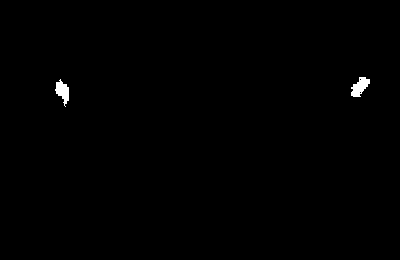

In [ ]:
# Display ground truth
import random
idx = random.randrange(0, 1000)
print(idx)
display_mask(dataset[783]['abnormality_mask'])

## Classification Model 


In [15]:
import sklearn
import numpy as np
import matplotlib.pyplot as plt
def classifier_evaluation_metrics(val_dataloader, model):
  """ Expects input in N x CL x H x W, CL is number of classes"""
 
  total_accuracy = 0
  total_samples = 0
  confusion_matrix = np.zeros((2, 2))
  for batch in val_dataloader:
    radiograph = batch['radiograph'].cuda()
    num_samples = radiograph.shape[0]
    label = batch['label'][1].detach().cpu().numpy()
    predicted_label = (model(radiograph)[1] > 0.5).float().squeeze(0).detach().cpu().numpy()


    accuracy = sk_accuracy(predicted_label, label)
    cm = sklearn.metrics.confusion_matrix(predicted_label, label, normalize = 'all')
    confusion_matrix += cm * num_samples

    total_accuracy += num_samples * accuracy
    total_samples += num_samples
    del radiograph

  confusion_matrix = confusion_matrix / total_samples 
  cm_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix)
  cm_display.plot()
  plt.show()
  accuracy = total_accuracy / total_samples 
  print("ACCURACY", accuracy)



""" Helper function to train  amodel with given hyperparameters """
def classifier_training_loop(train_dataset, val_dataset, model, optim = None, num_epochs = 3, lr=1e-4, reg=8e-3, batch_size=2, print_every = 100):
  losses = []
  train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
  val_dataloader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)
  size = int(0.2 * len(train_dataset))
  train_subset, _ = random_split(train_dataset, [size, len(train_dataset) - size])
  train_subset_dl = DataLoader(train_subset, batch_size = batch_size, shuffle = False)
  # Add more weight to positive examples 
  weight = torch.tensor([2, 1.0]).cuda()
  loss_fn = nn.CrossEntropyLoss(weight = weight)

  # Configure optimizer 
  if optim == None:
    optim = torch.optim.Adam(model.parameters(), lr = lr, weight_decay = reg)

  for i in range(num_epochs):
    print("EPOCH", i)

    total_loss = 0
    total_imgs = 0
    total_batches = 0
    
    model.eval()
    # Run validation 
    print("VAL METRICS")
    classifier_evaluation_metrics(val_dataloader, model)
    print("TRAIN METRICS")
    classifier_evaluation_metrics(train_subset_dl, model)

    model.train()
    for batch in train_dataloader:
      # Data
      radiograph = batch['radiograph'].cuda()
      label = batch['label'].cuda()
      # print(label.shape)

      optim.zero_grad() # Zero gradient 
      
      # Run model
      y_hat = model(radiograph).squeeze(-1)

      # Compute loss 
      loss = loss_fn(y_hat, label.float())
      
      # Backpropogate loss
      loss.backward()

      # Update gradients 
      optim.step()

      # Random Bookkeeping 
      total_loss += loss.data * radiograph.shape[0]
      total_imgs += radiograph.shape[0]
      total_batches += 1

      # if total_batches % print_every == 0:
      #   print('Loss', (total_loss / total_imgs).item())
      losses.append((total_loss / total_imgs).item())
    print("TRAINING LOSS", (total_loss / total_imgs).item())
    
    model.eval()
    val_count = 0
    val_loss = 0
    for batch in val_dataloader:
      radiograph = batch['radiograph'].cuda()
      label = batch['label'].cuda()
      optim.zero_grad()
      y_hat = model(radiograph).squeeze(-1)

      # Compute loss 
      loss = loss_fn(y_hat, label.float())
      val_loss += radiograph.shape[0] * loss.data
      val_count += radiograph.shape[0]
    print("VALIDATION LOSS", (val_loss / val_count).item())

    classifier_evaluation_metrics(val_dataloader, model)
  return losses


EPOCH 0
VAL METRICS


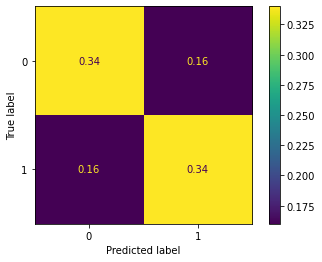

ACCURACY 0.68
TRAIN METRICS


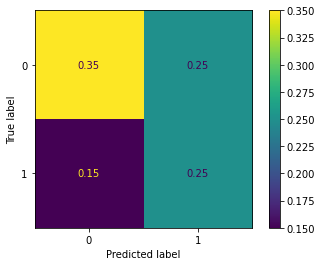

ACCURACY 0.6
TRAINING LOSS 0.8578334450721741
VALIDATION LOSS 1.0163546800613403


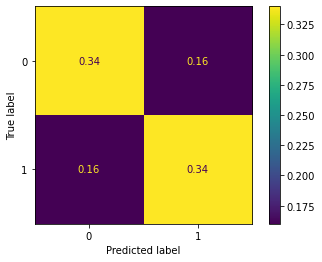

ACCURACY 0.68
EPOCH 1
VAL METRICS


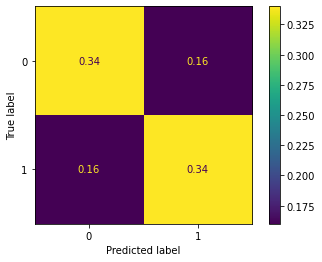

ACCURACY 0.68
TRAIN METRICS


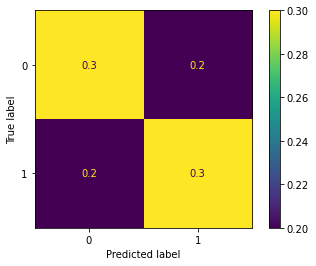

ACCURACY 0.6
TRAINING LOSS 0.44122013449668884
VALIDATION LOSS 1.3933417797088623


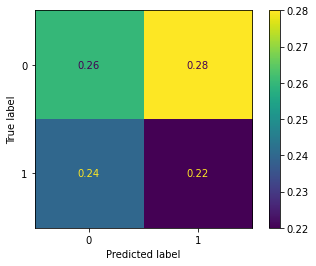

ACCURACY 0.48
EPOCH 2
VAL METRICS


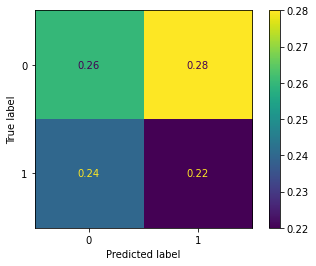

ACCURACY 0.48
TRAIN METRICS


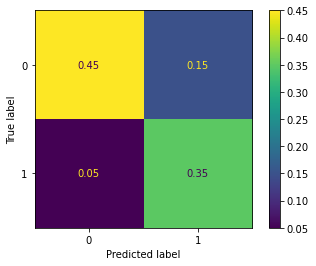

ACCURACY 0.8
TRAINING LOSS 0.1702631711959839
VALIDATION LOSS 1.271119475364685


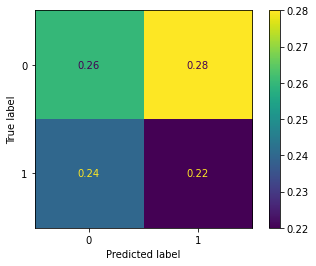

ACCURACY 0.48


In [ ]:
torch.cuda.empty_cache()
class_model = torchvision.models.resnet18(pretrained = True).cuda()
class_model.fc = nn.Linear(512, 2).cuda()

loss = classifier_training_loop(train_dataset, val_dataset, class_model, batch_size = 16)


In [ ]:
# plot training loss
from matplotlib import pyplot as plt
plt.plot(losses)
plt.show()

## Replicating https://ieeexplore.ieee.org/document/9293765/ 


In [ ]:
import torch.nn as nn
model = torch.nn.Sequential(
    nn.Conv2D(32, 5)
)

## Random Messing Around Below Here

In [ ]:
# Expert/ 
#   Expert/mask: 
#      abnormality mask 
# Student/ 
# Segmentation/ 
# Radiographs/ 

PIL is a library for displaying and showing images and has good Pytorch integration https://pillow.readthedocs.io/en/stable/reference/Image.html 

In [ ]:
# Display radiograph 
im = Image.open('Radiographs/1.JPG')

# Convert to tensor
# Radiographs are from zero to one
transform = transforms.ToTensor()
tensor = transform(im)
tensor.shape
print(tensor[:, 600, 600])
# TODO: zero center data? 
print(torch.min(tensor))
im

In [ ]:
# Mask of abnormality 
im = Image.open('Expert/mask/1.JPG')

im

In [ ]:
im = Image.open('Segmentation/teeth_mask/1.jpg')
im

In [ ]:
!stat  Expert/expert.json
!stat Segmentation/teeth_polygon.json
!stat Segmentation/teeth_bbox.json

In [ ]:
def generate

In [ ]:
def generate_label_dictionary():
  raw_bounding_boxes = json.load(open('Segmentation/teeth_bbox.json', 'r'))
  for label in raw_bounding_boxes:
    labels[label['External ID']] = label
  

In [ ]:
import json, torchvision

raw_labels = json.load(open('Segmentation/teeth_bbox.json', 'r'))
labels = {}
for label in raw_labels:
  labels[label['External ID']] = label
im = Image.open('Segmentation/teeth_mask/1.jpg')
tensor = transform(im)

print(labels['1.jpg'])
print(labels['1.jpg']['Label']['objects'])

boxes = []
for label in labels['1.jpg']['Label']['objects']:
  y1, x1, y2, x2 = label['bounding box']
  boxes.append(torch.tensor((x1, y1, x2, y2)).reshape(1, 4))
boxes = torch.cat(boxes)
#boxes = torch.tensor([x['bounding box'] for x in labels['1.jpg']['Label']['objects']])

print(boxes.shape)
boxed = torchvision.utils.draw_bounding_boxes((tensor * 255).to(torch.uint8), boxes, width=3)
transforms.ToPILImage()(boxed)

In [ ]:
polygons = json.load(open('Segmentation/teeth_polygon.json', 'r'))
polygons[0]['Labels'].keys()

In [ ]:
polygons[0]['Label']['objects'][0]['polygons'][2]

```teeth_bbox.json```: Contains bounding box and label for each tooth. \\
```teeth_polygon.json```: Contains bounding box, label, and list of polygons for each point. 
```Segmentation/teeth_mask```: Contains a mask for where teeth are. Teeth aren't labeled though. 
